In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [ ]:
# location which conda is installed in
!which conda
!conda --version

/usr/local/bin/conda
conda 23.1.0


In [ ]:

!conda install pandas numpy matplotlib ucimlrepo

Solving environment: - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - ucimlrepo

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
!conda create --name my_env python=3.8
!conda activate my_env

| / - \ | / - \ | / - \ | / - \ | / - \ | / done
#
# To activate this environment, use
#
#     $ conda activate my_env
#
# To deactivate an active environment, use
#
#     $ conda deactivate


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda activate my_env
python --version
conda deactivate

Python 3.8.18


In [5]:
!pip install ucimlrepo

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
warnings.filterwarnings('ignore')

## OBESITY, multi-class dataset

In [36]:
obesity = pd.read_csv('https://raw.githubusercontent.com/k-choonkiat/CS7641-supervised_learning/main/ObesityDataSet_raw_and_data_sinthetic.csv')
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [37]:
## Mapping columns where it is about frequency to ordinal variables
ordinal_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
obesity['CAEC'] = obesity['CAEC'].map(ordinal_map)
obesity['CALC'] = obesity['CALC'].map(ordinal_map)

## Mapping columns where it is about frequency to binary variables
binary_map =  {'no': 0, 'yes': 1}
obesity['family_history_with_overweight'] = obesity['family_history_with_overweight'].map(binary_map)
obesity['FAVC'] = obesity['FAVC'].map(binary_map)
obesity['SMOKE'] = obesity['SMOKE'].map(binary_map)
obesity['SCC'] = obesity['SCC'].map(binary_map)

## Encoding gender
gender_map =  {'Female': 0, 'Male': 1}
obesity['Gender'] = obesity['Gender'].map(gender_map)

## Mapping columns where it is categorical variables
obesity = pd.get_dummies(obesity, columns=['MTRANS'])

In [38]:
corr = obesity.corr()
corr.style.background_gradient(cmap='coolwarm')
# Here we can see that height and weight have high correkation and so we can actually combine them to form BMI which is a better indicator of overall health rather than just height and weight
# We also see high correlation between family

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
Gender,1.000000,0.048394,0.618466,0.161668,0.102512,0.064934,-0.274505,0.067600,-0.091543,0.044698,0.107930,-0.102633,0.189607,0.017269,-0.007616,0.137560,0.057001,0.045203,-0.160184,0.039317
Age,0.048394,1.000000,-0.025958,0.202560,0.205725,0.063902,0.016291,-0.043944,-0.083739,0.091987,-0.045304,-0.116283,-0.144938,-0.296931,0.044487,0.604683,0.003652,0.020286,-0.554448,-0.063064
Height,0.618466,-0.025958,1.000000,0.463136,0.247684,0.178364,-0.038121,0.243672,-0.048818,0.055499,0.213376,-0.133753,0.294709,0.051912,0.129732,0.077851,0.028996,-0.010471,-0.089684,0.036951
Weight,0.161668,0.202560,0.463136,1.000000,0.496820,0.272300,0.216125,0.107469,-0.287493,0.025746,0.200575,-0.201906,-0.051436,-0.071561,0.206677,-0.013619,-0.021745,-0.037300,0.059332,-0.100805
family_history_with_overweight,0.102512,0.205725,0.247684,0.496820,1.000000,0.208036,0.040372,0.071370,-0.169787,0.017385,0.147437,-0.185422,-0.056673,0.022943,-0.036676,0.099327,-0.015435,-0.051011,-0.058927,-0.067076
FAVC,0.064934,0.063902,0.178364,0.272300,0.208036,1.000000,-0.027283,-0.007000,-0.150068,-0.050660,0.009719,-0.190658,-0.107995,0.068417,0.089520,0.057597,-0.082005,-0.035401,0.028539,-0.179473
FCVC,-0.274505,0.016291,-0.038121,0.216125,0.040372,-0.027283,1.000000,0.042216,0.054670,0.014320,0.068461,0.071852,0.019939,-0.101135,0.060781,-0.061049,-0.029843,-0.007512,0.057966,0.013991
NCP,0.067600,-0.043944,0.243672,0.107469,0.071370,-0.007000,0.042216,1.000000,0.097801,0.007811,0.057088,-0.015624,0.129504,0.036326,0.071747,0.053424,0.023312,0.003875,-0.056849,0.006502
CAEC,-0.091543,-0.083739,-0.048818,-0.287493,-0.169787,-0.150068,0.054670,0.097801,1.000000,0.055282,-0.144995,0.109179,0.030110,0.048567,-0.047540,-0.044925,0.017857,0.076583,-0.003013,0.082571
SMOKE,0.044698,0.091987,0.055499,0.025746,0.017385,-0.050660,0.014320,0.007811,0.055282,1.000000,-0.031995,0.047731,0.011216,0.017613,0.082471,0.011873,-0.008416,0.035496,-0.022409,0.017184


In [39]:
obesity['BMI'] = obesity['Weight'] / obesity['Height'] **2
obesity = obesity.drop(columns=['Weight', 'Height'])

In [40]:
# We should only fit and transform the training data but apply the same scaling to test
scaler = StandardScaler()
numeric_features = ['Age','FCVC','NCP','CH2O','FAF','TUE','CALC', 'BMI']
obesity[numeric_features] = scaler.fit_transform(obesity[numeric_features])

In [41]:
X = obesity.drop(columns=['NObeyesdad'])
y = obesity['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

DIABETES, 2 class dataset

## Decision Trees

# Hyperparameter tuning

In [ ]:
import sklearn
!pip install scikit-learn --upgrade
sklearn.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


'1.2.2'

## Obesity SVM hyperparameter tuning

### Choosing kernels

In [ ]:
## F1 SCORE CODE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

pos_labels = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III']
cv = KFold(n_splits=5, shuffle=False)
kernels = ['rbf','linear','poly','sigmoid']
scores = []
for kernel in kernels:
  clf = SVC(kernel=kernel)
  curr = []
  for train_index, test_index in cv.split(X_train):
      X_ktrain, X_ktest = X_train.iloc[train_index], X_train.iloc[test_index]
      y_ktrain, y_ktest = y_train.iloc[train_index], y_train.iloc[test_index]
      clf = clf.fit(X_ktrain, y_ktrain)
      y_pred = clf.predict(X_ktest)
      score = f1_score(y_ktest, y_pred, average='micro',labels = pos_labels)
      curr.append(score)
  scores.append(score)
print(list(zip(kernels,scores)))

[('rbf', 0.9436201780415431), ('linear', 0.9643916913946587), ('poly', 0.9287833827893175), ('sigmoid', 0.5727002967359051)]


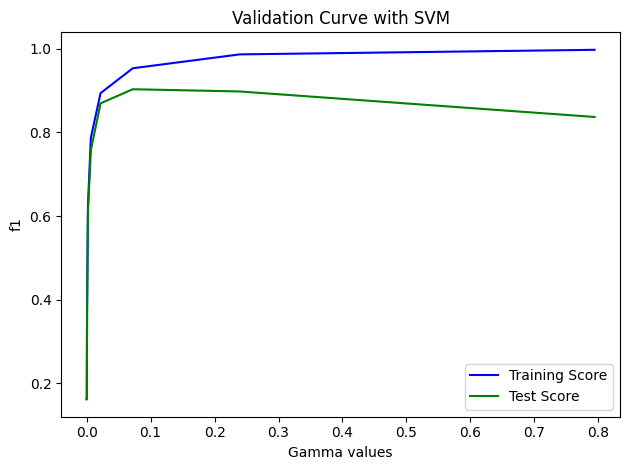

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
# gamma parameter with 5-fold cross validation
parameter_range = np.logspace(-10, -.1, 20)
train_score, test_score = validation_curve(SVC(kernel='rbf'), X_train, y_train,
                                           param_name="gamma",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with SVM")
plt.xlabel("Gamma values")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

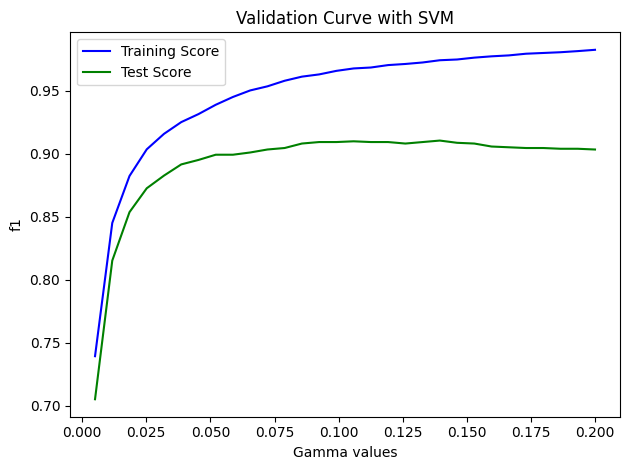

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
# gamma parameter with 5-fold cross validation
parameter_range = np.linspace(0.005, .2, 30)
train_score, test_score = validation_curve(SVC(kernel='rbf'), X_train, y_train,
                                           param_name="gamma",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with SVM")
plt.xlabel("Gamma values")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

In [ ]:
## F1 SCORE CODE
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f1_score(y_test, y_pred, average=None))

## Obesity Decision kNN hyperparameter tuning

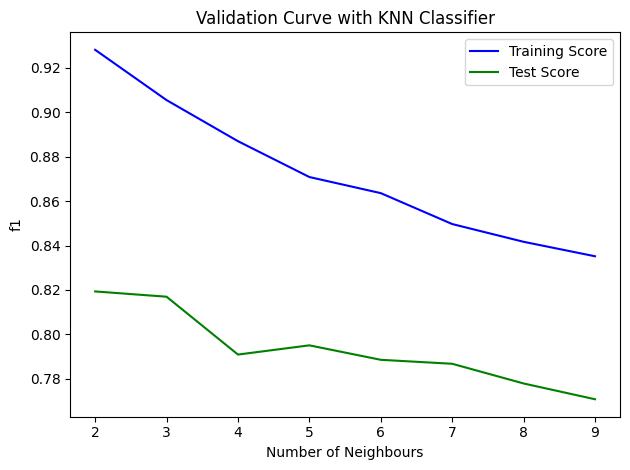

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
# gamma parameter with 5-fold cross validation
parameter_range = np.arange(2, 10, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

# Obesity decision tree tuning

### Choosing scoring method

In [ ]:
## F1 SCORE CODE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

pos_labels = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III']
cv = KFold(n_splits=5, shuffle=False)
criterions = ['gini','entropy','log_loss']
scores = []
for criterion in criterions:
  clf = DecisionTreeClassifier(criterion=criterion)
  curr = []
  for train_index, test_index in cv.split(X_train):
      X_ktrain, X_ktest = X_train.iloc[train_index], X_train.iloc[test_index]
      y_ktrain, y_ktest = y_train.iloc[train_index], y_train.iloc[test_index]
      clf = clf.fit(X_ktrain, y_ktrain)
      y_pred = clf.predict(X_ktest)
      score = f1_score(y_ktest, y_pred, average='micro',labels = pos_labels)
      curr.append(score)
  scores.append(score)
print(list(zip(criterions,scores)))

[('gini', 0.973293768545994), ('entropy', 0.9673590504451038), ('log_loss', 0.9673590504451038)]


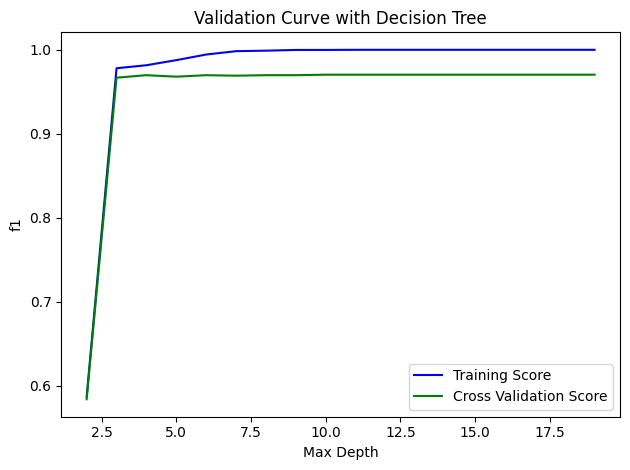

In [ ]:
# gamma parameter with 5-fold cross validation
parameter_range = np.arange(2, 20, 1)
pos_label = ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
train_score, test_score = validation_curve(DecisionTreeClassifier(random_state=0), X_train, y_train,
                                           param_name="max_depth",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve with Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

In [ ]:
print(list(zip(parameter_range,mean_test_score)))
print(list(zip(parameter_range,mean_train_score)))

[(4, 0.9697592395691128), (5, 0.9679912573734736), (6, 0.9697496327377138), (7, 0.9692056077578032), (8, 0.9698125627652934), (9, 0.9698028276834527), (10, 0.9704017445129086), (11, 0.9704088728109974), (12, 0.9704088728109974), (13, 0.9704088728109974), (14, 0.9704088728109974), (15, 0.9704088728109974), (16, 0.9704088728109974), (17, 0.9704088728109974), (18, 0.9704088728109974), (19, 0.9704088728109974)]
[(4, 0.981584757211974), (5, 0.9876989327784973), (6, 0.9943707635128826), (7, 0.9983708173784235), (8, 0.9989632600230974), (9, 0.9998519563831184), (10, 0.9998519563831184), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0)]


### F1 score for multi class label

## Obesity neural network

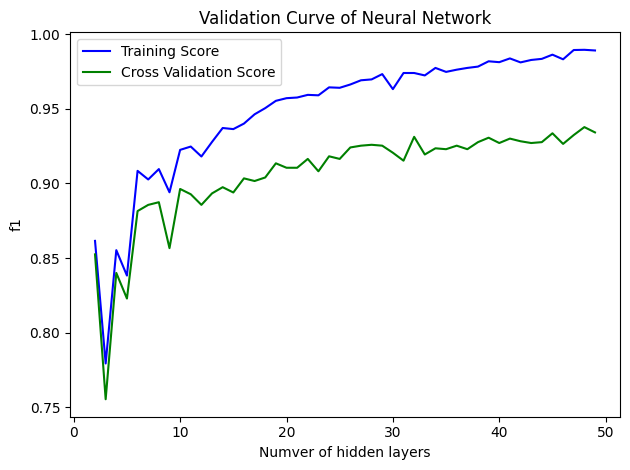

In [ ]:
parameter_range = np.arange(2,50,1)
train_score, test_score = validation_curve( MLPClassifier(random_state=1, max_iter=300),
                                           X_train,
                                           y_train,
                                           param_name="hidden_layer_sizes",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve of Neural Network")
plt.xlabel("Numver of hidden layers")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

## Obesity decision tree with boosting algorithm

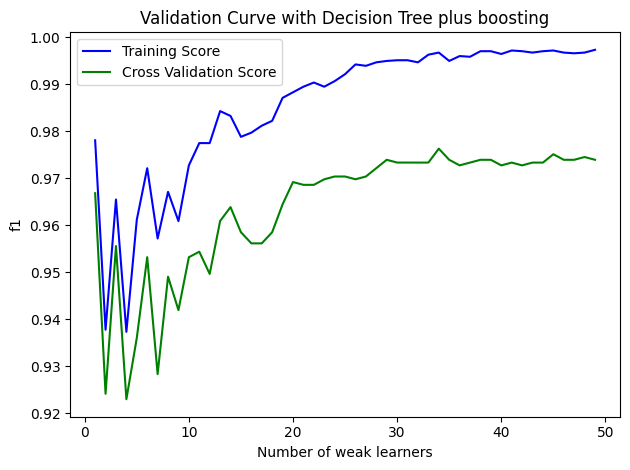

In [97]:
# gamma parameter with 5-fold cross validation
weak_learner = DecisionTreeClassifier()
parameter_range = np.arange(1, 50, 1)
train_score, test_score = validation_curve( AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=42),
                                           X_train,
                                           y_train,
                                           param_name="n_estimators",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve with Decision Tree plus boosting")
plt.xlabel("Number of weak learners")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

# Learning Curves

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

Text(0.5, 1.0, 'Learning Curve for MLPClassifier')

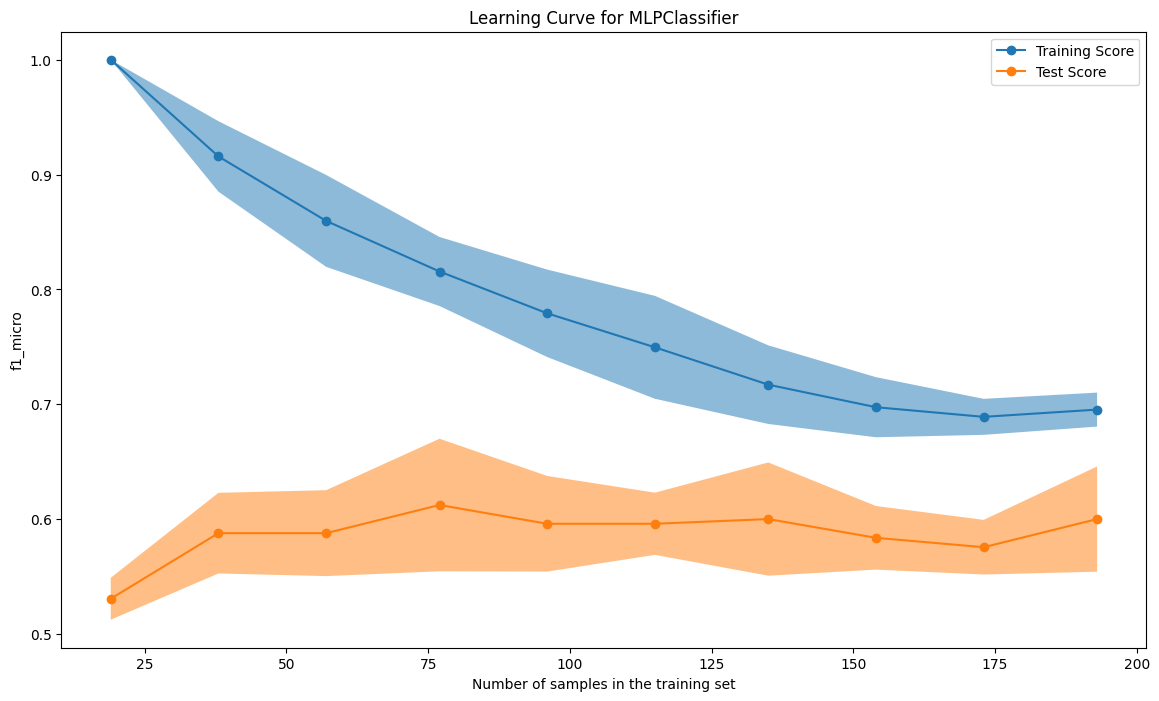

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=15, max_iter=300)
LearningCurveDisplay.from_estimator(mlp, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {mlp.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for SVC')

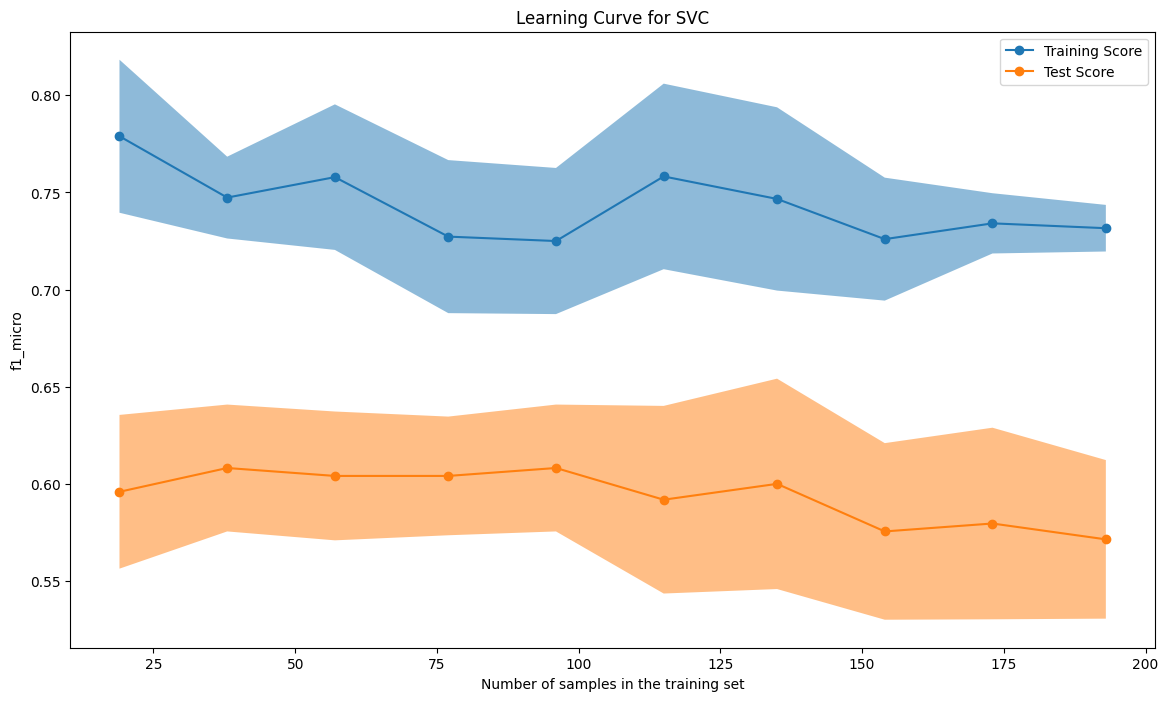

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
svc = SVC(kernel="rbf", gamma=0.072)
LearningCurveDisplay.from_estimator(svc, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {svc.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for DecisionTreeClassifier')

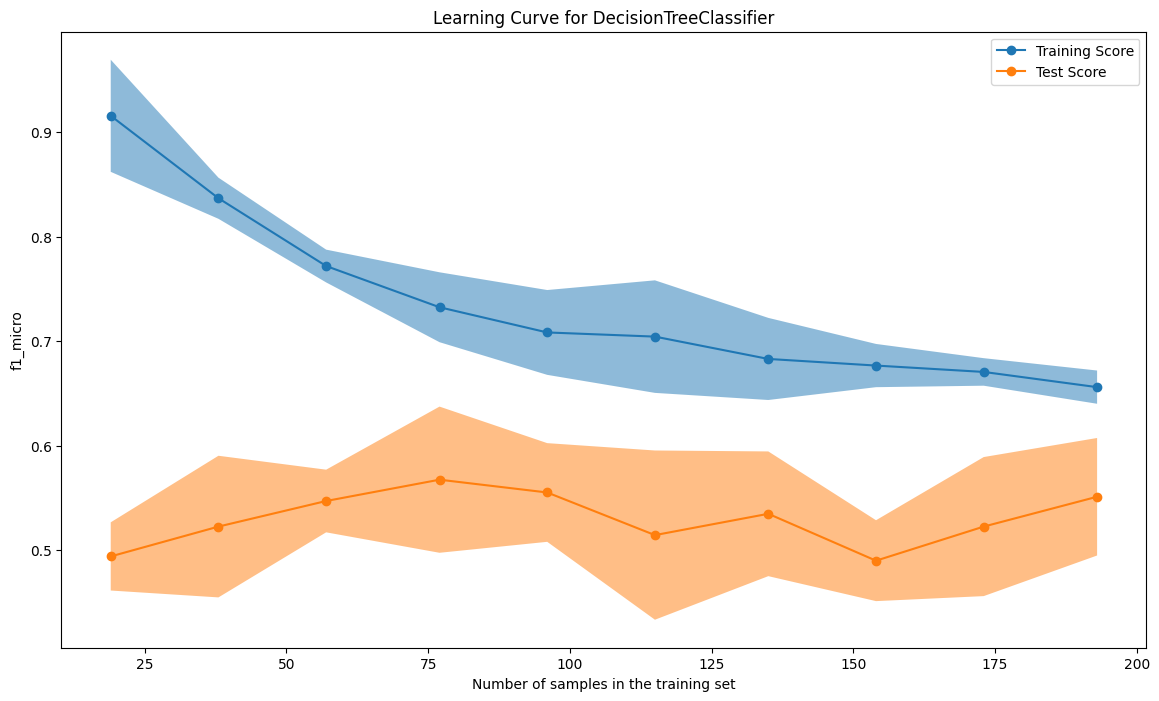

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
tree= DecisionTreeClassifier(max_depth=3,random_state=0)
LearningCurveDisplay.from_estimator(tree, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {tree.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for AdaBoostClassifier')

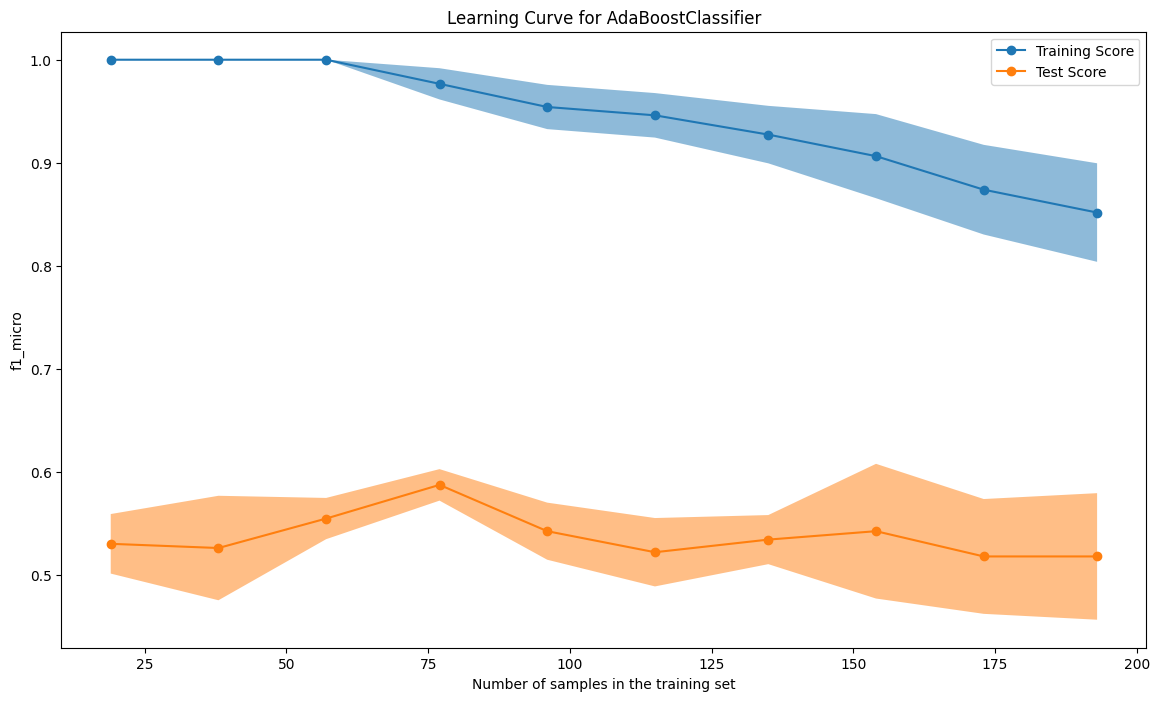

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
boosting = AdaBoostClassifier(tree, n_estimators=20, random_state=42)
LearningCurveDisplay.from_estimator(boosting, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {boosting.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

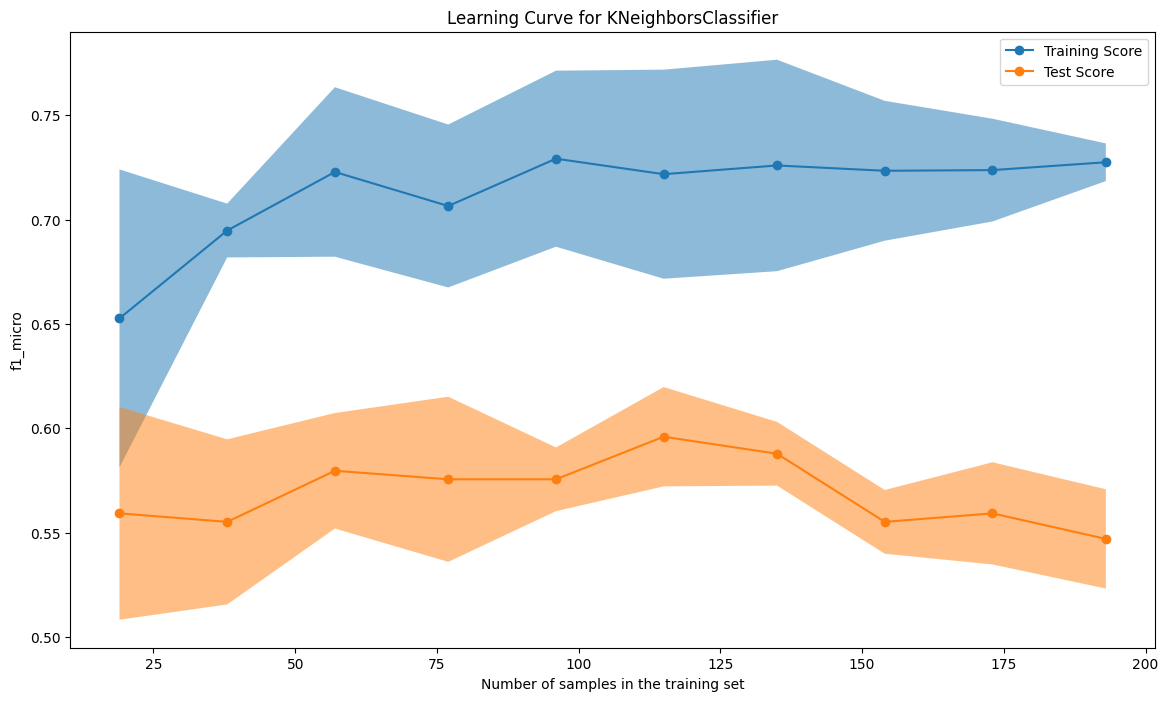

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
neigh = KNeighborsClassifier(n_neighbors=3)
LearningCurveDisplay.from_estimator(neigh, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {neigh.__class__.__name__}")

# Heart disease dataset

In [7]:
#from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)
# filling up missing values
X = X.fillna(X.mean())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [100]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.359489,0.127368
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.092891,0.379300
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.232332,0.264895
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098707,0.133534
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.118525,0.014190
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.143967,0.070658
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.127487,0.024449
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.263408,-0.278530
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.144722,0.328291
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.294558,0.340549


In [8]:
X['cp'] = X['cp'].astype(str)
ordinal_map = {'1': 'chest_pain_typical_angina', '2': 'chest_pain_atypical_angina', '3': 'chest_pain_non_angina_pain', '4': 'chest_pain_asymptomatic'}
X['cp'] = X['cp'].map(ordinal_map)
X['slope'] = X['slope'].astype(str)
slope_map = {'1': 'upsloping', '2': 'flat', '3': 'downsloping'}
X['slope'] = X['slope'].map(slope_map)
X['thal'] = X['thal'].astype(str)
thal_map = {'3.0': 'normal', '6.0': 'fixed_defect', '7.0': 'reversible_defect'}
X['thal'] = X['thal'].map(thal_map)
X = pd.get_dummies(X, columns=['cp','slope','thal'])

In [9]:
# We should only fit and transform the training data but apply the same scaling to test
scaler = StandardScaler()
numeric_features = ['age','trestbps','chol','thalach','restecg','oldpeak','ca']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

## Hyperparameters tuning

### Decision tree hyperparameter tuning

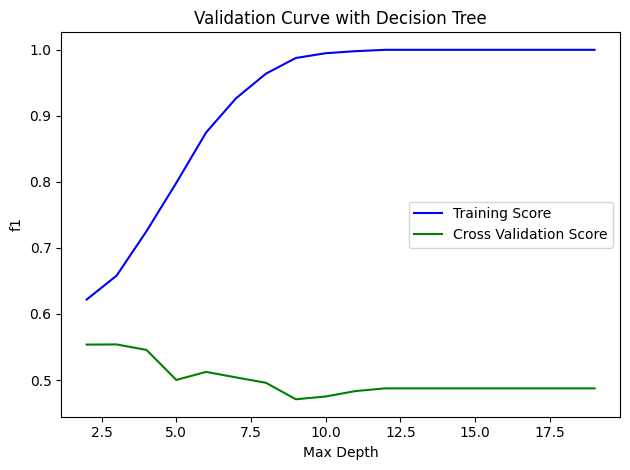

In [40]:
# gamma parameter with 5-fold cross validation
parameter_range = np.arange(2, 20, 1)
train_score, test_score = validation_curve(DecisionTreeClassifier(random_state=0), X_train, y_train,
                                           param_name="max_depth",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve with Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

### Neural network hyperparameters tuning

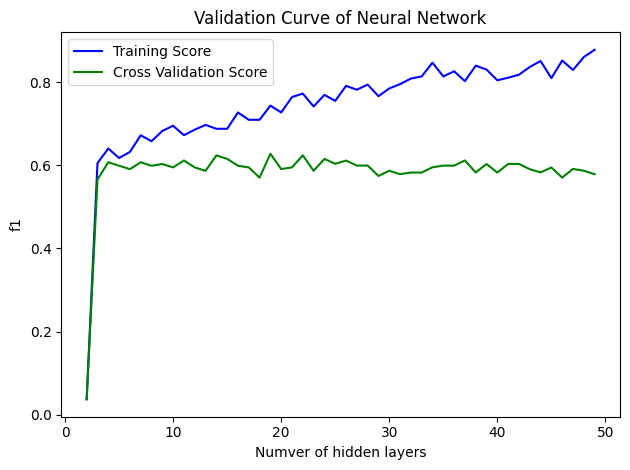

In [41]:
parameter_range = np.arange(2,50,1)
train_score, test_score = validation_curve( MLPClassifier(random_state=1, max_iter=300),
                                           X_train,
                                           y_train,
                                           param_name="hidden_layer_sizes",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve of Neural Network")
plt.xlabel("Numver of hidden layers")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

## Boosted decision trees hyperparameters tuning

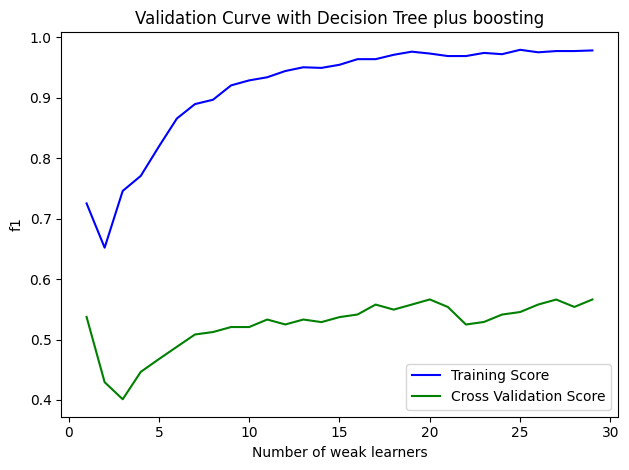

In [47]:
weak_learner = DecisionTreeClassifier(max_depth=4)
parameter_range = np.arange(1, 30, 1)
train_score, test_score = validation_curve( AdaBoostClassifier(weak_learner, random_state=42),
                                           X_train,
                                           y_train,
                                           param_name="n_estimators",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", color='g')

# Creating the plot
plt.title("Validation Curve with Decision Tree plus boosting")
plt.xlabel("Number of weak learners")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

## SVM hyperparameters tuning

In [52]:
y['num'].unique()

array([0, 2, 1, 3, 4])

In [53]:
## F1 SCORE CODE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

pos_labels = [0,1,2,3,4]
cv = KFold(n_splits=5, shuffle=False)
kernels = ['rbf','linear','poly','sigmoid']
scores = []
for kernel in kernels:
  clf = SVC(kernel=kernel)
  curr = []
  for train_index, test_index in cv.split(X_train):
      X_ktrain, X_ktest = X_train.iloc[train_index], X_train.iloc[test_index]
      y_ktrain, y_ktest = y_train.iloc[train_index], y_train.iloc[test_index]
      clf = clf.fit(X_ktrain, y_ktrain)
      y_pred = clf.predict(X_ktest)
      score = f1_score(y_ktest, y_pred, average='micro',labels = pos_labels)
      curr.append(score)
  scores.append(score)
print(list(zip(kernels,scores)))

[('rbf', 0.6041666666666666), ('linear', 0.6458333333333334), ('poly', 0.5833333333333334), ('sigmoid', 0.6041666666666666)]


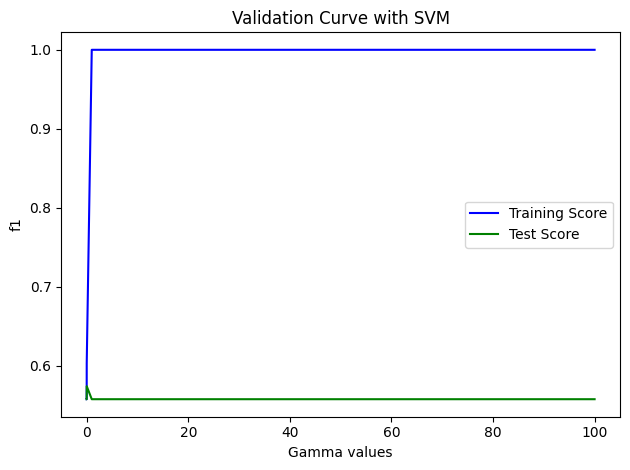

In [90]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
# gamma parameter with 5-fold cross validation
parameter_range = np.logspace(-8, 2, 6)
train_score, test_score = validation_curve(SVC(kernel='rbf'), X_train, y_train,
                                           param_name="gamma",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with SVM")
plt.xlabel("Gamma values")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

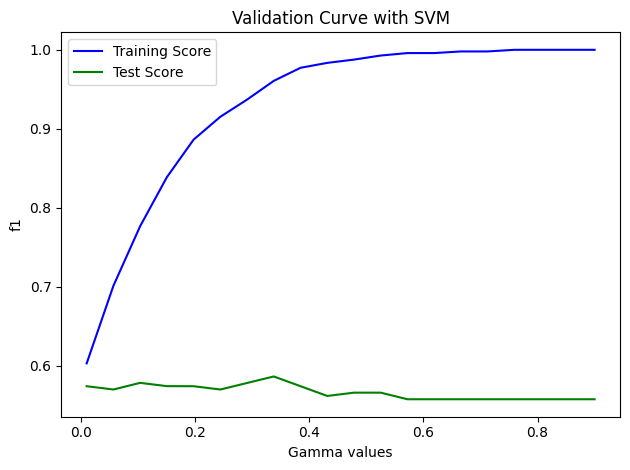

In [83]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
# gamma parameter with 5-fold cross validation
#parameter_range = np.logspace(-100000000, -1, 100)
parameter_range = np.linspace(0.01, .9, 20)
train_score, test_score = validation_curve(SVC(kernel='rbf'), X_train, y_train,
                                           param_name="gamma",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with SVM")
plt.xlabel("Gamma values")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

## kNN hyperparameters tuning

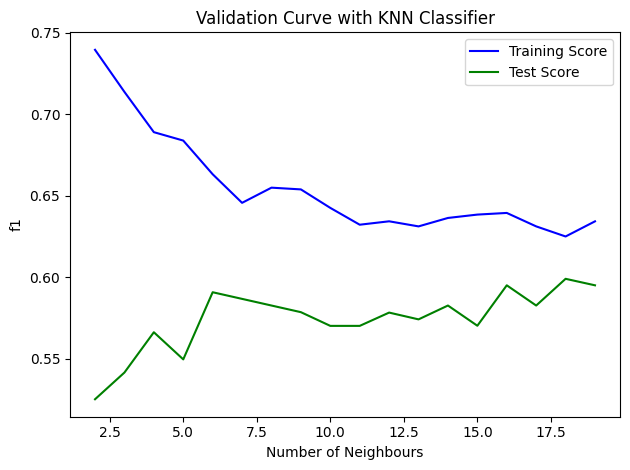

In [86]:
# gamma parameter with 5-fold cross validation
parameter_range = np.arange(2, 20, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_micro")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("f1")
plt.tight_layout()
plt.legend(loc='best')

## Learning Curves

In [30]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_micro",
}
# tree= DecisionTreeClassifier(max_depth=4,random_state=0)
# svc = SVC(kernel="rbf", gamma=0.33)
# neigh = KNeighborsClassifier(n_neighbors=6)
# boosting = AdaBoostClassifier(tree, n_estimators=10, random_state=42)

# LearningCurveDisplay.from_estimator(tree, **common_params, ax=ax)
# handles, label = ax.get_legend_handles_labels()
# ax.legend(handles[:2], ["Training Score", "Test Score"])
# ax.set_title(f"Learning Curve for {tree.__class__.__name__}")
# for ax_idx, estimator in enumerate([tree, mlp, boosting, svc, neigh]):
#     LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
#     handles, label = ax[ax_idx].get_legend_handles_labels()
#     ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#     ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for MLPClassifier')

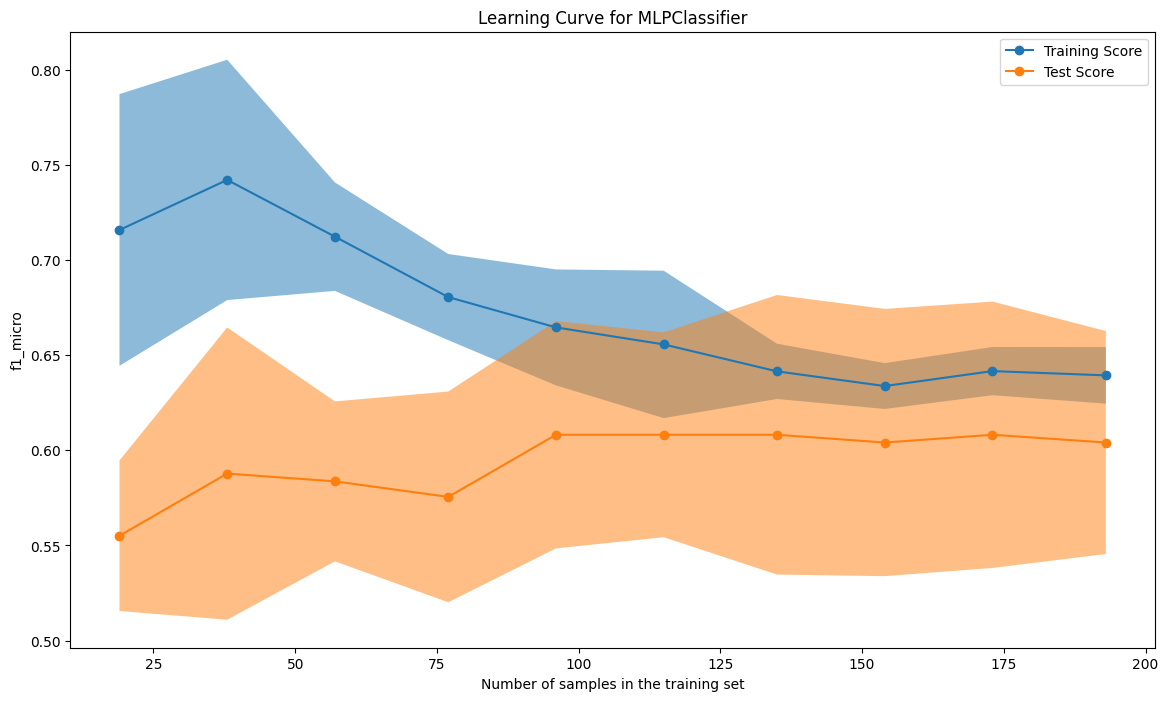

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=4, max_iter=300)
LearningCurveDisplay.from_estimator(mlp, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {mlp.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for SVC')

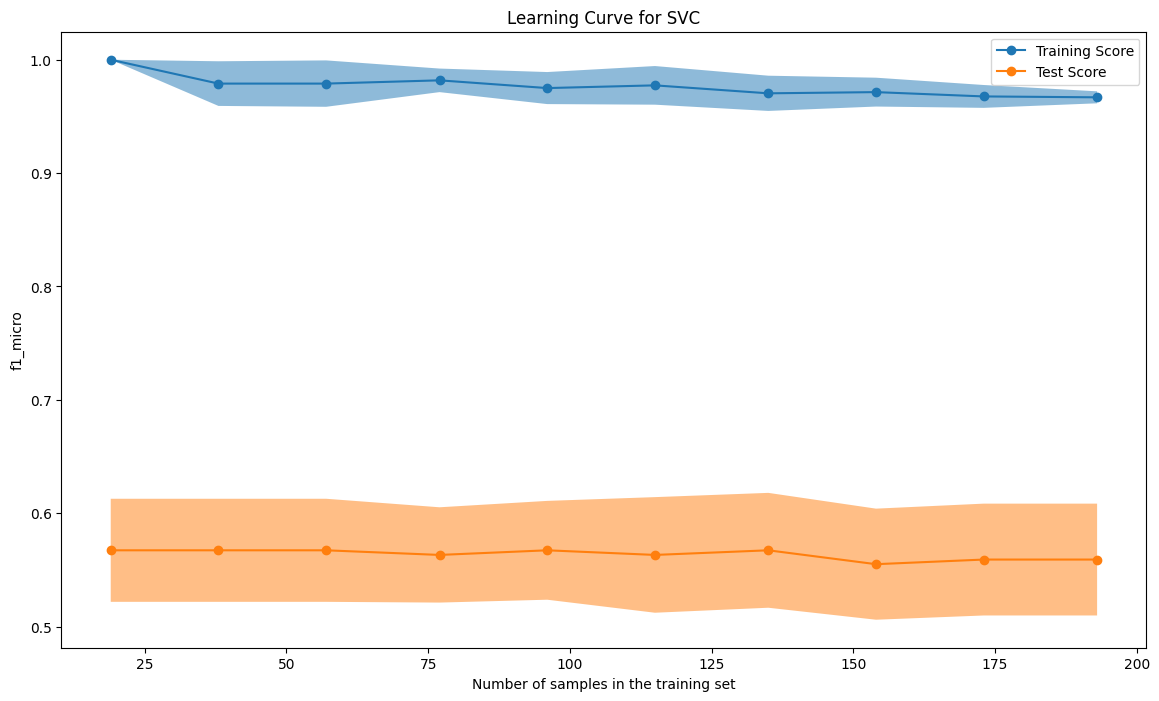

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
svc = SVC(kernel="rbf", gamma=0.33)
LearningCurveDisplay.from_estimator(svc, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {svc.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for DecisionTreeClassifier')

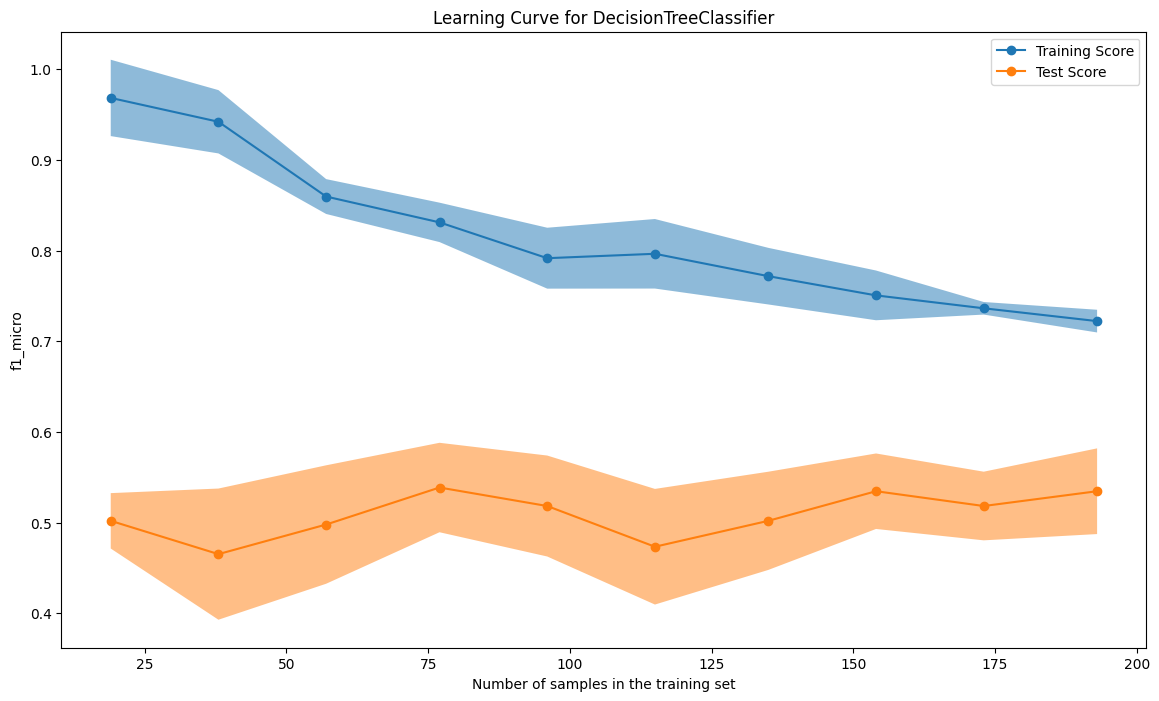

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
tree= DecisionTreeClassifier(max_depth=4,random_state=0)
LearningCurveDisplay.from_estimator(tree, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {tree.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for AdaBoostClassifier')

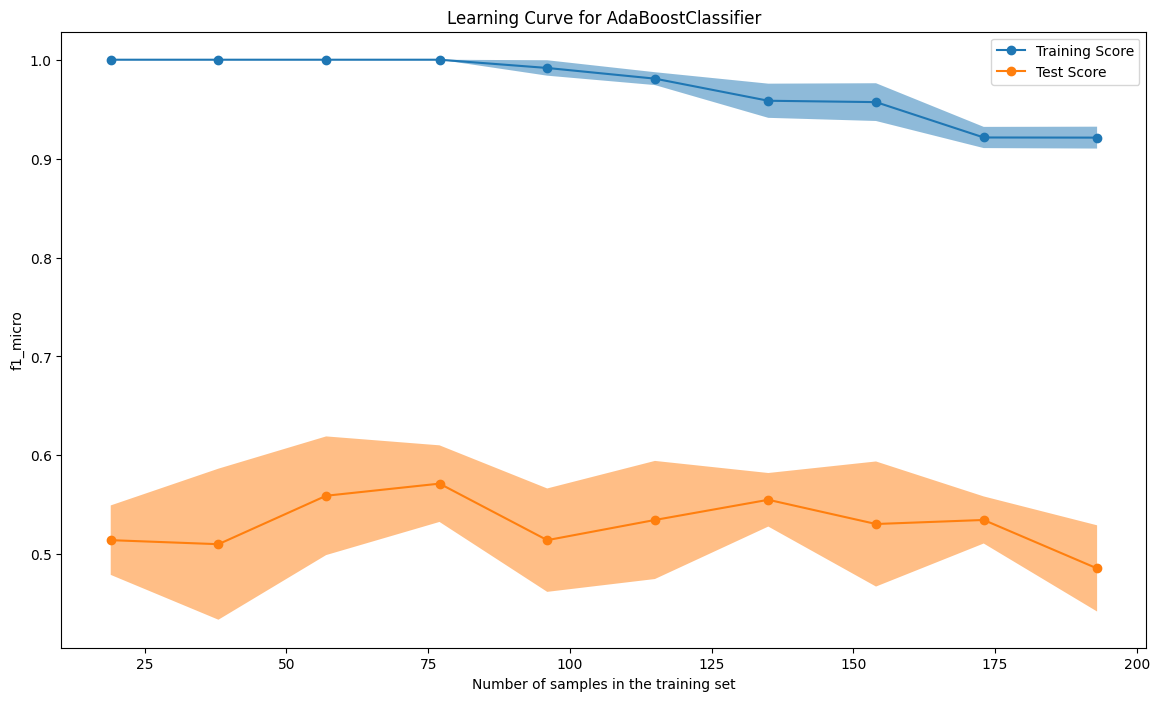

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
boosting = AdaBoostClassifier(tree, n_estimators=10, random_state=42)
LearningCurveDisplay.from_estimator(boosting, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {boosting.__class__.__name__}")

Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

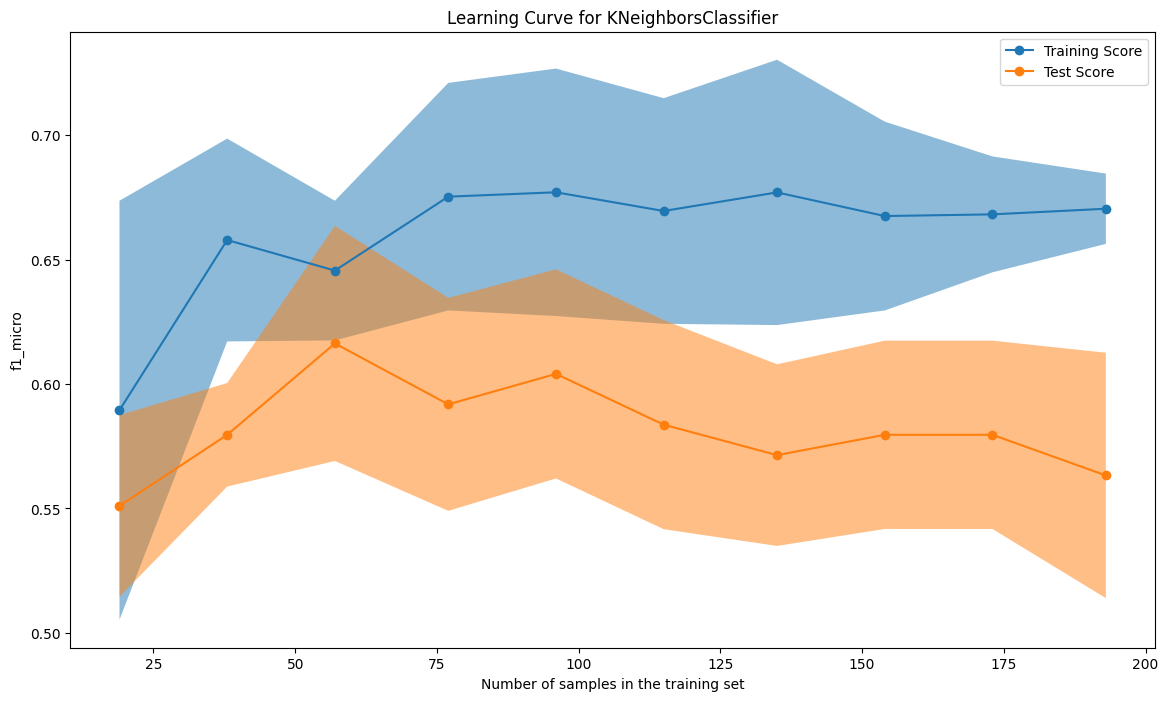

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharey=True)
neigh = KNeighborsClassifier(n_neighbors=6)
LearningCurveDisplay.from_estimator(neigh, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {neigh.__class__.__name__}")

## Test results